# Preparing _EmpCov_ prior for CIFAR-10

Here we compute the empirical covariance of patches of CIFAR-10 images for the _EmpCov_ prior.

In [1]:
import os
from jax import numpy as jnp
import numpy as onp
import jax
import tensorflow.compat.v2 as tf
import argparse
import time
import tqdm
import haiku as hk
from collections import OrderedDict

from bnn_hmc.utils import data_utils
from bnn_hmc.utils import models
from bnn_hmc.utils import metrics
from bnn_hmc.utils import losses
from bnn_hmc.utils import checkpoint_utils
from bnn_hmc.utils import cmd_args_utils
from bnn_hmc.utils import logging_utils
from bnn_hmc.utils import train_utils
from bnn_hmc.utils import precision_utils

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
dtype = jnp.float32
train_set, test_set, task, data_info = data_utils.make_ds_pmap_fullbatch(
    "cifar10", dtype)
test_labels = test_set[1]

## Patch extraction

In [3]:
def extract_all_patches(x, kernel_size, padding):
    num_imgs, img_size, _, c = x.shape
    padded_x = onp.zeros((num_imgs, img_size + 2 * padding, img_size + 2 * padding, c))
    padded_x[:, padding:-padding, padding:-padding, :] = x
    
    img_size += 2 * padding
    n_shifts = img_size - kernel_size
    
    hor_shifts = jnp.arange(1, n_shifts)
    ver_shifts = jnp.arange(1, n_shifts)
    hor_shifts, ver_shifts = jnp.meshgrid(hor_shifts, ver_shifts)
    hor_shifts = hor_shifts.reshape(-1)
    ver_shifts = ver_shifts.reshape(-1)
    
    all_patches = onp.zeros((num_imgs, (n_shifts-1)**2, kernel_size, kernel_size, c))
    for i in tqdm.tqdm(range(kernel_size)):
        for j in range(kernel_size):
            all_patches[:, :, i, j] = onp.asarray(padded_x[:, hor_shifts + i, ver_shifts + j])
    return all_patches.reshape((-1, kernel_size, kernel_size, c))


def get_pca(x):
    pca = PCA()
    pca.fit(x)
    return pca

In [5]:
x_train = train_set[0]
x_train = x_train.reshape(-1, 32, 32, 3)
all_patches = extract_all_patches(x_train, 5, 2)

100%|██████████| 5/5 [01:59<00:00, 23.92s/it]


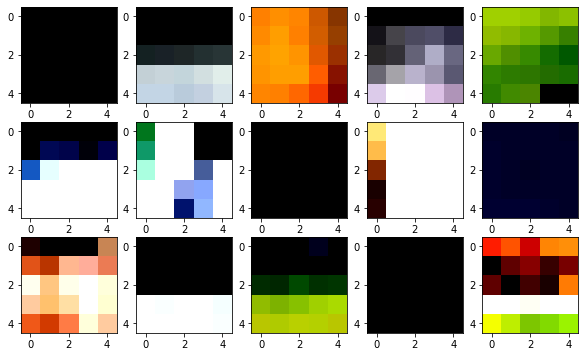

In [8]:
n_x, n_y = 5, 3
f, arr = plt.subplots(n_y, n_x, figsize=(n_x * 2, n_y * 2))
for i in range(n_y):
    for j in range(n_x):
        patch_id = onp.random.randint(len(all_patches))
        arr[i, j].imshow(all_patches[patch_id])

## PCA

In [9]:
all_patches_flat = all_patches.reshape((len(all_patches), -1))

In [10]:
pca = get_pca(all_patches_flat)
basis = pca.components_

onp.savez(  
    "cifar10_patch_pca.npz",
    components=pca.components_,
    mean=pca.mean_,
    explained_var=pca.explained_variance_,
    explained_var_ratio=pca.explained_variance_ratio_
)

## Visualization

In [46]:
basis_imgs = basis.copy().reshape((75, 5, 5, 3))
basis_imgs -= basis_imgs.min(axis=(0, 1, 2))[None, None, None, :]
basis_imgs /= basis_imgs.max(axis=(0, 1, 2))[None, None, None, :]

Highest-variance components

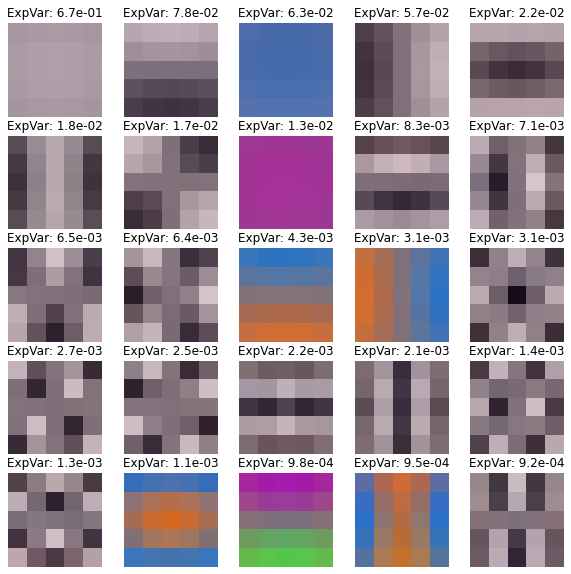

In [49]:

f, arr = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        component_id = i * 5 + j
        explained_var = pca.explained_variance_ratio_[component_id]
        arr[i, j].imshow(basis_imgs[component_id])
        arr[i, j].axis("off")
        arr[i, j].set_title("ExpVar: {:.1e}".format(explained_var))

Lowest-variance components

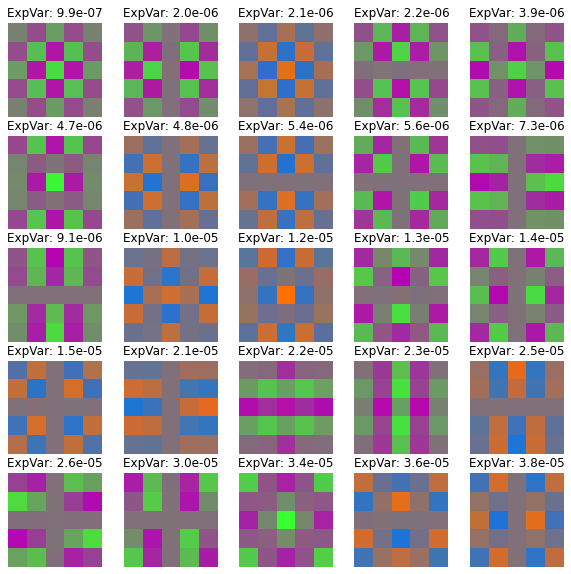

In [50]:
f, arr = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        component_id = -(i * 5 + j)-1
        explained_var = pca.explained_variance_ratio_[component_id]
        arr[i, j].imshow(basis_imgs[component_id])
        arr[i, j].axis("off")
        arr[i, j].set_title("ExpVar: {:.1e}".format(explained_var))

## Export covariance

In [4]:
arr = onp.load("cifar10_patch_pca.npz")
basis = arr["components"]
var = arr["explained_var"]

In [5]:
cov = basis.T @ jnp.diag(var) @ basis
inv_cov = jnp.linalg.inv(cov)

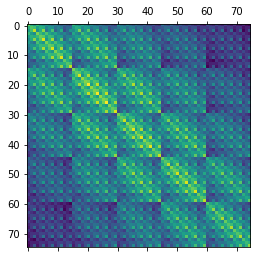

In [6]:
plt.matshow(cov)

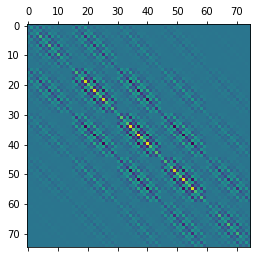

In [7]:
plt.matshow(inv_cov)

In [9]:
onp.save(  
    "../pca_covs/cifar_cnn_pca_cov.npz",
    cov
)
onp.save(  
    "../pca_covs/cifar_cnn_pca_inv_cov.npz",
    inv_cov
)